<img style="width:100%" src="../images/practical_xgboost_in_python_notebook_header.png" />

# Boosting - Wisdom of the Crowd (practice)
**This chapter includes**:
- <a href="#data-preparation">Data preparation</a>
- <a href="#sdt">Using single decision tree</a>
- <a href="#ada">Boosting with AdaBoost</a>
- <a href="#gbt">Gradient Boosted Trees - why not?</a>

Now let's time to see how boosting is applied in practice. Hopefully the `scikit-learn` package provides all described packages. Begin with importing all required libraries. XGBoost package will be described more in later lectures.

In [3]:
import numpy as np
import subprocess

from IPython.display import Image

from collections import Counter

from sklearn.datasets import make_classification
from sklearn.cross_validation import train_test_split
from sklearn.metrics import log_loss, accuracy_score

# classifiers
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.ensemble import AdaBoostClassifier
from sklearn.ensemble import GradientBoostingClassifier

# reproducibility
seed = 104

### Prepare data <a name='data-preparation' />
In all examples we will be dealing with **binary classification**.  Generate 20 dimensional artificial dataset with 1000 samples, where 8 features holding information, 3 are redundant and 2 repeated.

In [4]:
X, y = make_classification(n_samples=1000, n_features=20, n_informative=8, n_redundant=3, n_repeated=2, random_state=seed)

And finally perform a split into train/test parts. It will be useful for validating the performance of all methods.

In [5]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=seed)

All algorithms won't be tuned at this point. A sensible set of default settings will be applied, making the whole things less complicated.

> [*Logarithmic loss*](https://www.kaggle.com/wiki/LogarithmicLoss) and accuracy were chosen to evaluate the results. It's also important to remeber about reproducibility - you should always set all `seed` parameters to the same value.

Let's perform a target variable distribution sanity check before digging into algorithms.

In [6]:
print("Train label distribution:")
print(Counter(y_train))

print("\nTest label distribution:")
print(Counter(y_test))

Train label distribution:
Counter({1: 405, 0: 395})

Test label distribution:
Counter({0: 104, 1: 96})


Target variable is equally distribued across both dataset.

### Single Decision Tree <a name='sdt' />
The following code will create a single decision tree, fit it using training data and evaluate the results using test sample.

In [7]:
decision_tree = DecisionTreeClassifier(random_state=seed)

# train classifier
decision_tree.fit(X_train, y_train)

# predict output
decision_tree_y_pred  = decision_tree.predict(X_test)
decision_tree_y_pred_prob  = decision_tree.predict_proba(X_test)

# evaluation
decision_tree_accuracy = accuracy_score(y_test, decision_tree_y_pred)
decision_tree_logloss = log_loss(y_test, decision_tree_y_pred_prob)

print("== Decision Tree ==")
print("Accuracy: {0:.2f}".format(decision_tree_accuracy))
print("Log loss: {0:.2f}".format(decision_tree_logloss))
print("Number of nodes created: {}".format(decision_tree.tree_.node_count))

== Decision Tree ==
Accuracy: 0.78
Log loss: 7.60
Number of nodes created: 167


We can see two things:

1. the log loss score is not very promising (due to the fact that leaves in decision tree outputs either `0` or `1` as probability which is heaviliy penalized in case of errors, but the accuracy score is quite decent,
2. the tree is complicated (large number of nodes)

You can inspect first few predicted outputs, and see that only 2 instances out of 5 were classified correctly.

In [8]:
print('True labels:')
print(y_test[:5,])
print('\nPredicted labels:')
print(decision_tree_y_pred[:5,])
print('\nPredicted probabilities:')
print(decision_tree_y_pred_prob[:5,])

True labels:
[1 1 1 0 1]

Predicted labels:
[0 0 1 0 0]

Predicted probabilities:
[[ 1.  0.]
 [ 1.  0.]
 [ 0.  1.]
 [ 1.  0.]
 [ 1.  0.]]


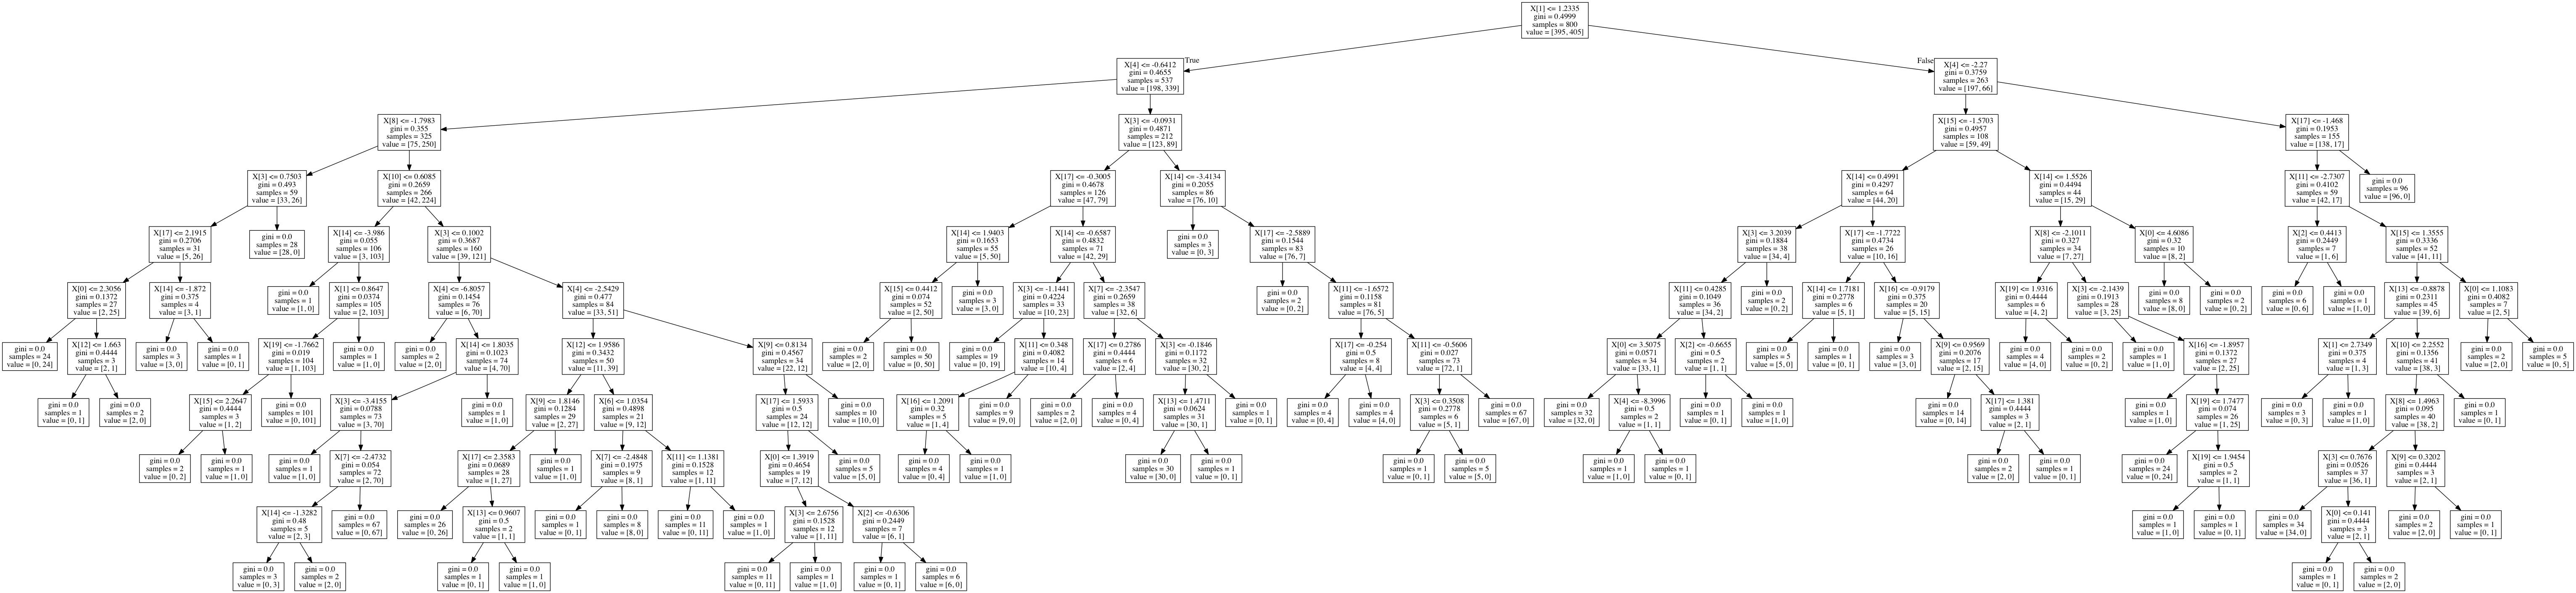

In [9]:
dt_viz_file = '../images/dt.dot'
dt_png_file = '../images/dt.png'

# create visualization
export_graphviz(decision_tree, out_file=dt_viz_file)

# convert to PNG
command = ["dot", "-Tpng", dt_viz_file, "-o", dt_png_file]
subprocess.check_call(command)

# display image
Image(filename=dt_png_file)

### AdaBoost <a name='ada' />
In the example below we are creating a AdaBoost classifier running on 1000 iterations (1000 trees created). Also we are growing decision node up to first split (they are called *decision stumps*). We are also going to use `SAMME` algorithm which is inteneded to work with discrete data (output from `base_estimator` is `0` or `1`). Please refer to the [documentation](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.AdaBoostClassifier.html) and [here](http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_hastie_10_2.html) for more details.

In [8]:
adaboost = AdaBoostClassifier(
    base_estimator=DecisionTreeClassifier(max_depth=1),
    algorithm='SAMME',
    n_estimators=1000,
    random_state=seed)

# train classifier
adaboost.fit(X_train, y_train)

# calculate predictions
adaboost_y_pred = adaboost.predict(X_test)
adaboost_y_pred_prob = adaboost.predict_proba(X_test)

# evaluate
adaboost_accuracy = accuracy_score(y_test, adaboost_y_pred)
adaboost_logloss = log_loss(y_test, adaboost_y_pred_prob)

print("== AdaBoost ==")
print("Accuracy: {0:.2f}".format(adaboost_accuracy))
print("Log loss: {0:.2f}".format(adaboost_logloss))

== AdaBoost ==
Accuracy: 0.78
Log loss: 0.69


The log-loss metrics is much lower than in single decision tree (mainly to the fact that now we obtain probabilities output). The accuracy is the same, but notice that the structure of the tree is much simpler. We are creating 1000 **decision tree stumps**.

Also here a quick peek into predicted values show that now 4 out of 5 first test instances are classified correctly.

In [9]:
print('True labels:')
print(y_test[:5,])
print('\nPredicted labels:')
print(adaboost_y_pred[:5,])
print('\nPredicted probabilities:')
print(adaboost_y_pred_prob[:5,])

True labels:
[1 1 1 0 1]

Predicted labels:
[1 0 1 0 1]

Predicted probabilities:
[[ 0.50211294  0.49788706]
 [ 0.5021334   0.4978666 ]
 [ 0.50162035  0.49837965]
 [ 0.51639587  0.48360413]
 [ 0.49926165  0.50073835]]


Just for clarity, let's check how the first tree looks like.

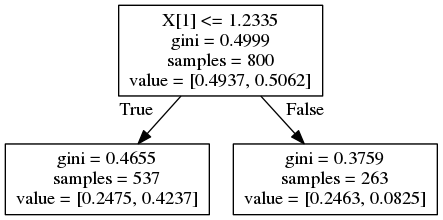

In [10]:
ada_t1 = adaboost.estimators_[0]
ada_t1_viz_file = '../images/ada-t1.dot'
ada_t1_png_file = '../images/ada-t1.png'

# create visualization
export_graphviz(ada_t1, out_file=ada_t1_viz_file)

# convert to PNG
command = ["dot", "-Tpng", ada_t1_viz_file, "-o", ada_t1_png_file]
subprocess.check_call(command)

# display image
Image(filename=ada_t1_png_file)

What's it's error and contribution into final ensemble

In [11]:
print("Error: {0:.2f}".format(adaboost.estimator_errors_[0]))
print("Tree importance: {0:.2f}".format(adaboost.estimator_weights_[0]))

Error: 0.33
Tree importance: 0.71


### Gradient Boosted Trees<a name='gbt' />
Let's construct a gradient boosted tree consiting of 1000 trees where each successive one will be created with gradient optimization. Again we are going to leave most parameters with their default values, specifiy only maximum depth of the tree to 1 (again decision stumps), and setting warm start for more intelligent computations. Please refer to the [docs](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html) if something is not clear.

In [12]:
gbc = GradientBoostingClassifier(
    max_depth=1,
    n_estimators=1000,
    warm_start=True,
    random_state=seed)
gbc.fit(X_train, y_train)

# make predictions
gbc_y_pred = gbc.predict(X_test)
gbc_y_pred_prob = gbc.predict_proba(X_test)

# calculate log loss
gbc_accuracy = accuracy_score(y_test, gbc_y_pred)
gbc_logloss = log_loss(y_test, gbc_y_pred_prob)

print("== Gradient Boosting ==")
print("Accuracy: {0:.2f}".format(gbc_accuracy))
print("Log loss: {0:.2f}".format(gbc_logloss))

== Gradient Boosting ==
Accuracy: 0.81
Log loss: 0.48


The obtained results are obviously the best of all presented algorithm. We have obtained most accurate algorithm giving more sensible predictions about class probabilities.

In [13]:
print('True labels:')
print(y_test[:5,])
print('\nPredicted labels:')
print(gbc_y_pred[:5,])
print('\nPredicted probabilities:')
print(gbc_y_pred_prob[:5,])

True labels:
[1 1 1 0 1]

Predicted labels:
[1 0 1 0 1]

Predicted probabilities:
[[ 0.3698346   0.6301654 ]
 [ 0.77521996  0.22478004]
 [ 0.45077105  0.54922895]
 [ 0.9660623   0.0339377 ]
 [ 0.31039421  0.68960579]]


The difference is that GBC uses `DecisionTreeRegressor` classifier as the estimator with *mean-square error* as criterion. This results of slightly different output of the tree - now the leaf contains a predicted value (while the first splitting point remains the same).

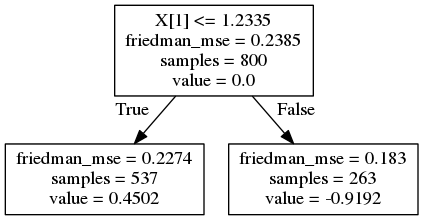

In [14]:
gbc_t1 = gbc.estimators_[2][0]
gbc_t1_viz_file = '../images/gbc-t1.dot'
gbc_t1_png_file = '../images/gbc-t1.png'

# create visualization
export_graphviz(gbc_t1, out_file=gbc_t1_viz_file)

# convert to PNG
command = ["dot", "-Tpng", gbc_t1_viz_file, "-o", gbc_t1_png_file]
subprocess.check_call(command)

# display image
Image(filename=gbc_t1_png_file)